In [164]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz

# 1. Prepare the dataset: Identify Y

In [108]:
df = pd.read_csv('bank_marketing.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,51,management,married,tertiary,no,6530,yes,no,unknown,5,may,91,1,-1,0,unknown,no
1,27,unemployed,married,primary,no,7459,yes,no,unknown,9,may,407,2,-1,0,unknown,no
2,59,management,divorced,primary,no,13308,yes,no,unknown,13,may,131,1,-1,0,unknown,no
3,48,technician,married,secondary,no,7373,yes,no,unknown,14,may,126,1,-1,0,unknown,no
4,51,blue-collar,married,secondary,no,7180,yes,no,unknown,14,may,927,1,-1,0,unknown,yes


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35134 entries, 0 to 35133
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        35134 non-null  int64 
 1   job        35134 non-null  object
 2   marital    35134 non-null  object
 3   education  35134 non-null  object
 4   default    35134 non-null  object
 5   balance    35134 non-null  int64 
 6   housing    35134 non-null  object
 7   loan       35134 non-null  object
 8   contact    35134 non-null  object
 9   day        35134 non-null  int64 
 10  month      35134 non-null  object
 11  duration   35134 non-null  int64 
 12  campaign   35134 non-null  int64 
 13  pdays      35134 non-null  int64 
 14  previous   35134 non-null  int64 
 15  poutcome   35134 non-null  object
 16  y          35134 non-null  object
dtypes: int64(7), object(10)
memory usage: 4.6+ MB


In [110]:
#no null values
df.isnull().values.any()

False

In [111]:
#look at categorical attributes
for col in df.select_dtypes(include='object').columns:
    print(col,':' ,df[col].unique(), '\n')

job : ['management' 'unemployed' 'technician' 'blue-collar' 'admin' 'services'
 'self-employed' 'housemaid' 'unknown' 'retired' 'entrepreneur' 'student'] 

marital : ['married' 'divorced' 'single'] 

education : ['tertiary' 'primary' 'secondary' 'unknown'] 

default : ['no' 'yes'] 

housing : ['yes' 'no'] 

loan : ['no' 'yes'] 

contact : ['unknown' 'cellular' 'telephone'] 

month : ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'jan' 'feb' 'mar' 'apr' 'sep' 'dec'] 

poutcome : ['unknown' 'failure' 'other' 'success'] 

y : ['no' 'yes'] 



In [112]:
#look at value counts for target attribute
df.y.value_counts()

no     31005
yes     4129
Name: y, dtype: int64

In [113]:
#class balance of target attrinnbute
class_bal = df.y.value_counts()/df.y.count()
class_bal

no     0.882479
yes    0.117521
Name: y, dtype: float64

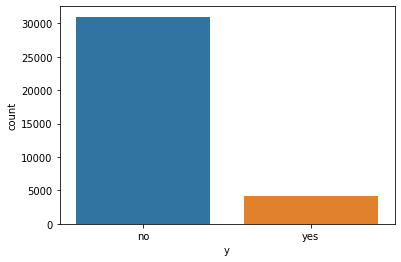

In [114]:
sns.countplot(data=df,x='y')

# 2 Select several Xs and transform them into categorical classes (aggregate the values into reasonable classes).

Information gain provides a way to use entropy to calculate how a change to the dataset impacts the purity of the dataset, e.g. the distribution of classes. A smaller entropy suggests more purity or less surprise.

https://machinelearningmastery.com/information-gain-and-mutual-information/#:~:text=Information%20gain%20is%20calculated%20by,when%20applied%20to%20variable%20selection.

In [115]:
#drop unnecessary attributes
df.drop("pdays",inplace=True,axis=1)
df.drop(df[df['previous']>30].index,axis=0,inplace=True)

In [116]:
#remove outliers from remaining attributes
df.drop(df[(df['balance']>40000)|(df['balance']<0)].index,inplace=True,axis=0) # negative bank balances
df.drop(df[df['duration']>3000].index,inplace=True,axis=0) #outliers on large duration (skews data the higher the duration is)
df.drop(df[df['campaign']>30].index,axis=0,inplace=True) #drop campaign outliers

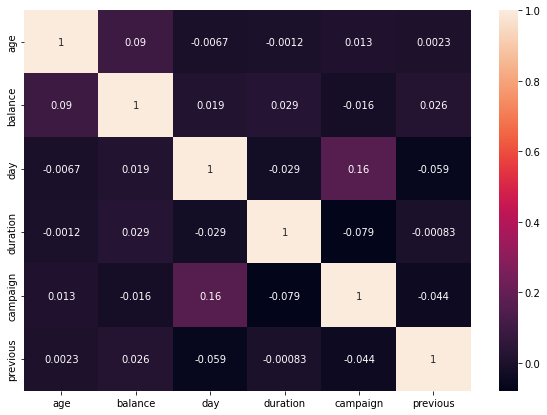

In [117]:
df_num = df[['age', 'balance', 'day', 'duration', 'campaign', 'previous']]
plt.figure(figsize=(10,7))
sns.heatmap(data=df_num.corr(), annot=True)
plt.show()

Label Encoding for Categorical Features

We have several attributes with more than 2 categories

In [118]:
# Label Encoding is a popular encoding technique for handling categorical variables. 
# Each label is assigned a unique integer based on alphabetical ordering

le = LabelEncoder()
df.marital = le.fit_transform(df.marital)
df.housing = le.fit_transform(df.housing)
df.y = le.fit_transform(df.y)
df.loan = le.fit_transform(df.loan)
df.default = le.fit_transform(df.default)


# One hot encoding
def get_encoder_inst(feature_col):
  
    assert isinstance(feature_col, pd.Series)
    feature_vec = feature_col.sort_values().values.reshape(-1, 1)
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(feature_vec) 
  
    filename = '.pickle'
    pickle.dump(enc, open(filename, 'wb'))
    return enc

def get_one_hot_enc(feature_col, enc,cols):
  
    assert isinstance(feature_col, pd.Series)
    assert isinstance(enc, OneHotEncoder)
    unseen_vec = feature_col.values.reshape(-1, 1)
    encoded_vec = enc.transform(unseen_vec).toarray()
    column_name = enc.get_feature_names([cols])
    encoded_df = pd.DataFrame(encoded_vec, columns= column_name)
    return encoded_df

ohe_cat_list = ['job','education','contact','month','poutcome']
ohe_cat_data = df[ohe_cat_list]
df.drop(ohe_cat_list,axis=1,inplace=True)

data_list = []
for cols in ohe_cat_data.columns:
    encoder = get_encoder_inst(ohe_cat_data[cols])
    one = get_one_hot_enc(ohe_cat_data[cols],encoder,cols)
    data_list.append(one)
    
final_ohe = pd.concat(data_list,axis=1)
df.reset_index(drop=True, inplace=True)
final_ohe.reset_index(drop=True, inplace=True)
for cols in final_ohe.columns:
    final_ohe[cols] = final_ohe[cols].astype('int')


df = pd.concat([df,final_ohe],axis=1)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framewo

In [119]:
df

,age,marital,default,balance,housing,loan,day,duration,campaign,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,51,1,0,6530,1,0,5,91,1,0,...,0,0,1,0,0,0,0,0,0,1
1,27,1,0,7459,1,0,9,407,2,0,...,0,0,1,0,0,0,0,0,0,1
2,59,0,0,13308,1,0,13,131,1,0,...,0,0,1,0,0,0,0,0,0,1
3,48,1,0,7373,1,0,14,126,1,0,...,0,0,1,0,0,0,0,0,0,1
4,51,1,0,7180,1,0,14,927,1,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32076,51,1,0,825,0,0,17,977,3,0,...,0,0,0,1,0,0,0,0,0,1
32077,71,0,0,1729,0,0,17,456,2,0,...,0,0,0,1,0,0,0,0,0,1
32078,72,1,0,5715,0,0,17,1127,5,3,...,0,0,0,1,0,0,0,0,1,0
32079,57,1,0,668,0,0,17,508,4,0,...,0,0,0,1,0,0,0,0,0,1


In [120]:
df=df.reset_index()
df.drop('index',axis=1,inplace=True)

Data Preprocessing

In [121]:
X = df.drop('y',axis=1)
y = df['y']

In [122]:
X.head()

,age,marital,default,balance,housing,loan,day,duration,campaign,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,51,1,0,6530,1,0,5,91,1,0,...,0,0,1,0,0,0,0,0,0,1
1,27,1,0,7459,1,0,9,407,2,0,...,0,0,1,0,0,0,0,0,0,1
2,59,0,0,13308,1,0,13,131,1,0,...,0,0,1,0,0,0,0,0,0,1
3,48,1,0,7373,1,0,14,126,1,0,...,0,0,1,0,0,0,0,0,0,1
4,51,1,0,7180,1,0,14,927,1,0,...,0,0,1,0,0,0,0,0,0,1


In [133]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: y, dtype: int64

In [134]:
#K FOLD
KF = KFold(n_splits=3, shuffle=True)

for train_index, test_index in KF.split(X):
    X_train, X_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

print("Train data shape:{}".format(X_train.shape))
print("Test data shape:{}".format(X_test.shape))

Train data shape:(21388, 45)
Test data shape:(10693, 45)


In [135]:
# scaling
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)

In [136]:
#random forest model
rfc = RandomForestClassifier(n_estimators=18, max_depth=5, random_state=100, max_leaf_nodes=50)

In [137]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_leaf_nodes=50, n_estimators=18,
                       random_state=100)

In [139]:
rand_scores = cross_val_score(rfc, X_train, y_train, cv=3)
rand_mean = rand_scores.mean()


In [187]:
print('Report:\n',classification_report(y_test, y_pred))
print("F1 Score:",f1_score(y_pred,y_test))
print('confusion Matrix:\n',confusion_matrix(y_pred,y_test))
print('cross validation:',cross_val_score(rfc, X, y, cv=5))

Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      5673
           1       0.70      0.03      0.05       744

    accuracy                           0.89      6417
   macro avg       0.80      0.51      0.49      6417
weighted avg       0.87      0.89      0.84      6417

F1 Score: 0.04928664072632945
confusion Matrix:
 [[5665  725]
 [   8   19]]
cross validation: [0.87751286 0.87718204 0.87484414 0.8026808  0.82995636]


In [140]:
y_pred = rfc.predict(X_test)

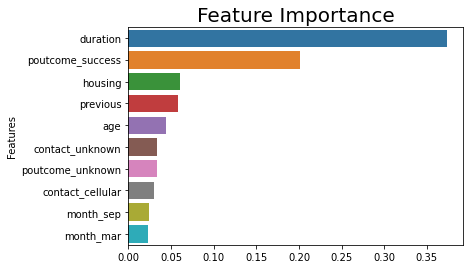

In [141]:
importances=rfc.feature_importances_
feature_importances=pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=feature_importances[0:10], y=feature_importances.index[0:10])
plt.title('Feature Importance', size=20)
plt.ylabel("Features")
plt.show()

In [165]:
list(rfc.classes_)

[0, 1]

In [166]:
estimator = rfc.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, 
                out_file='tree.dot', 
                feature_names = list(X.columns),
                class_names = list(rfc.classes_),
                rounded = True, 
                proportion = False, 
                precision = 2,
                filled = True)

TypeError: can only concatenate str (not "numpy.int64") to str

In [169]:
# Convert to png
from subprocess import call
call(['dot', '-Tpng', '/Users/allysonvasquez/Developer/6040_ModelMgmt/random_forest/tree.dot', '-o', '/Users/allysonvasquez/Developer/6040_ModelMgmt/random_forest/tree.png', '-Gdpi=600'])

Error: /Users/allysonvasquez/Developer/6040_ModelMgmt/random_forest/tree.dot: syntax error in line 4


1

In [168]:
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

FileNotFoundError: [Errno 2] No such file or directory: 'tree.png'

In [142]:
########### mutual infor stuff https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(RandomForestClassifier(n_estimators = 18))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=18))

In [143]:
sel.get_support()

array([ True,  True, False,  True, False, False,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False])

In [144]:
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat)

Index(['age', 'marital', 'balance', 'day', 'duration', 'campaign', 'previous',
       'poutcome_success'],
      dtype='object')


In [145]:
len(selected_feat)

8

In [196]:
from sklearn.feature_selection import mutual_info_classif
res = dict(zip(X_train.columns,
               mutual_info_classif(X, y, discrete_features=True)
               ))
print(res)

{'age': 0.01459017378898925, 'default': 0.0001311213312308818, 'balance': 0.09584376718000626, 'housing': 0.010323261779055876, 'loan': 0.002602816474885486, 'contact': 0.013578884024392224, 'day': 0.005878935578473118, 'month': 0.02465178472474771, 'duration': 0.09913313856249573, 'campaign': 0.004481280516053874, 'previous': 0.012948587836107318, 'poutcome': 0.03019403618594957, 'job_admin': 1.049309068031079e-05, 'job_blue-collar': 0.0030140618122596885, 'job_entrepreneur': 0.0002201454846460331, 'job_housemaid': 0.00021289539450190624, 'job_management': 0.0005592955406882455, 'job_retired': 0.0027276815051439987, 'job_self-employed': 2.109206428679844e-07, 'job_services': 0.0004956839039181107, 'job_student': 0.0023880591652553143, 'job_technician': 5.486985438746261e-05, 'job_unemployed': 0.00026964357024561805, 'job_unknown': 1.369830378798037e-07, 'marital_divorced': 3.9245862874653925e-06, 'marital_married': 0.0019053190608893933, 'marital_single': 0.0020553909434469775, 'educa

In [197]:
def ig(class_, feature):
  classes = set(class_)

  Hc = 0
  for c in classes:
    pc = list(class_).count(c)/len(class_)
    Hc += - pc * math.log(pc, 2)
  print('Overall Entropy:', Hc)
  feature_values = set(feature)

  Hc_feature = 0
  for feat in feature_values:

    pf = list(feature).count(feat)/len(feature)
    indices = [i for i in range(len(feature)) if feature[i] == feat]
    clasess_of_feat = [class_[i] for i in indices]
    for c in classes:
        pcf = clasess_of_feat.count(c)/len(clasess_of_feat)
        if pcf != 0:
            temp_H = - pf * pcf * math.log(pcf, 2)
            Hc_feature += temp_H
  ig = Hc - Hc_feature
  return ig    




3) Your job is to create TWO trees: 
- one with selecting the next X variable (at each level) with mutual information
- another with the standard mutual information.

4) Compare the performances of the two trees and see if one is better.

5) Obviously you need to program 2 Python functions that may be called to calculate either mutual information or the standard mutual information as needed. You would have to call one of them at every level to split the tree further.

6) In my opinion, once a tree is done, a forrest is easily created and the performance the forest may be evaluated comparatively with the others. But if you find it difficult, you may only do a simple tree.

7) An alternative approach would be to 
- (a) choose a package of random forest, which by default uses mutual information to select X variables at each tree node
- (b) swap out the mutual information by the (your own function of the standard mutual information).
- This way you would have 2 forests and then you can compare them.